# Fast Approximate MST Clustering Algorithm 

### Proposed Algorithm is named PNNG 

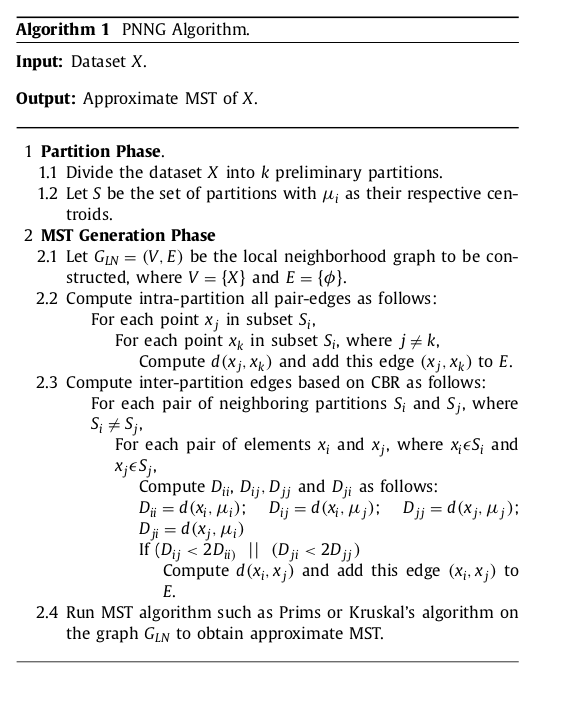

In [71]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
import sklearn
from sklearn import datasets
import matplotlib.lines as mlines
%matplotlib inline

In [72]:
def bimeans(vertices,N):
#     print vertices.shape[0]
    if vertices.shape[0]<=np.sqrt(N):
        return ([vertices])
    centroid=np.mean(vertices,axis=0)
    o=vertices[0]
    for v in vertices:
        if np.sqrt(np.sum((v-centroid)**2))<np.sqrt(np.sum((o-centroid)**2)):
            o=v
    q=vertices[0]
    for v in vertices:
        if np.sqrt(np.sum((v-o)**2))>np.sqrt(np.sum((q-o)**2)):
            q=v
    p=vertices[0]
    for v in vertices:
        if np.sqrt(np.sum((q-v)**2))>np.sqrt(np.sum((q-p)**2)):
            p=v
    lvertices=[]
    rvertices=[]
    for v in vertices:
        if np.sqrt(np.sum((p-v)**2))<=np.sqrt(np.sum((q-v)**2)):
            lvertices.append(v)
        else:
            rvertices.append(v)
    return (bimeans(np.array(lvertices),N)+bimeans(np.array(rvertices),N))


In [73]:
def kmeans(vertices,N):
    clusters=int(np.sqrt(N))
    centroids=np.random.rand(clusters)
    partitions=[np.zeros((0,vertices.shape[1])) for i in xrange(clusters)]
    for it in xrange(200):
        for i in xrange(len(partitions)):
            partitions[i]=np.zeros((0,vertices.shape[1]))
        for v in vertices:
                dist,best=np.inf,0
                for i in xrange(clusters):
                    curr=np.sqrt(np.sum(centroids[i]-v)**2)
                    if curr<dist:
                        dist,best=curr,i
                partitions[best]=np.concatenate((partitions[best],np.reshape(v,(1,v.shape[0]))),axis=0)
        centroids=np.array(map(lambda x:np.mean(x,axis=0),partitions))
    return partitions
    

In [74]:
# Will return adjacency list
def create_edges(vertices):
    N=vertices.shape[0]
    adj_list=[]
    for i in xrange(N):
        adj_list.append(list())
        for j in xrange(N):
            if i==j:
                continue
            adj_list[i].append((j,np.sqrt(np.sum((vertices[j]-vertices[i])**2))))
    return adj_list

In [75]:
#Minimum Spanning Tree (Prims Algorithm) | O(n^2) for Dense Graphs
# Will return tadj_list for the MST
def prims_mst(adj_list):   # AdjList[i]=list((v,cost))
    N=len(adj_list)
    edges=[]
    tadj_list=[[] for i in xrange(N)]
    mark=np.zeros((N+1))
    incoming=np.full((N+1,2),(N,np.inf))
    incoming[0]=(N,0)
    count=0
    while count<N:
        best_vertex=N
        for i in xrange(N):
            if (not mark[i])  and incoming[i][1]<=incoming[best_vertex][1]:
                best_vertex=i
        mark[best_vertex]=1
        if incoming[best_vertex][1]==np.inf:
            incoming[best_vertex][1]=0

        if incoming[best_vertex][0]!=N:
            tadj_list[int(incoming[best_vertex][0])].append((best_vertex,incoming[best_vertex][1]))
            tadj_list[best_vertex].append((int(incoming[best_vertex][0]),incoming[best_vertex][1]))
        count+=1
        
        for ed in adj_list[best_vertex]:
            if (not mark[ed[0]]) and ed[1]<incoming[ed[0]][1]:
                incoming[ed[0]]=(best_vertex,ed[1])
    return tadj_list

In [76]:
partition_func={'Bi-means':bimeans,'K-means':kmeans}

In [77]:
# Returns the pruned nearest neighbour graph 
# Return Vertices Set, Adjaceny List of NNG 

def pnng(dataset,partition_type='Bi-means'):
    
    X=dataset  
    partitions=partition_func[partition_type](X,X.shape[0])
    centroids=np.array(map(lambda p:np.mean(p,axis=0,dtype=np.float64),partitions))
    centroids_adj_list=create_edges(centroids)
    centroid_mst_adj_list=prims_mst(centroids_adj_list)
    heaviest_edge=0
    
    for i in centroid_mst_adj_list:
        for j in i:
            heaviest_edge=max(heaviest_edge,j[1])
    
    X=partitions[0]
    for i in xrange(1,len(partitions)):
        X=np.concatenate((X,partitions[i]),axis=0)
        
    N=X.shape[0]
    NNG_adj_list=[]
    
    cummulative_index=[]
    pre=0
    for P in partitions:
        cummulative_index.append(pre)
        P_adj_list=create_edges(P)
        NNG_adj_list=NNG_adj_list+P_adj_list
        pre+=P.shape[0]
    
    for i in xrange(len(partitions)):
        for j in xrange(len(partitions)):
            if i==j or np.sqrt(np.sum((centroids[i]-centroids[j])**2))>heaviest_edge:
                continue
            Pi=partitions[i]
            Pj=partitions[j]
            for a in xrange(Pi.shape[0]):
                for b in xrange(Pj.shape[0]):
                    Dii=np.sqrt(np.sum((Pi[a]-centroids[i])**2))
                    Dij=np.sqrt(np.sum((Pi[a]-centroids[j])**2))
                    Djj=np.sqrt(np.sum((Pj[b]-centroids[j])**2))
                    Dji=np.sqrt(np.sum((Pj[b]-centroids[i])**2))
                    if Dij<2*Dii or Dji<2*Djj:
                        NNG_adj_list[cummulative_index[i]+a].append((cummulative_index[j]+b,np.sqrt(np.sum((Pi[a]-Pj[b])**2))))
                        NNG_adj_list[cummulative_index[j]+b].append((cummulative_index[i]+a,np.sqrt(np.sum((Pi[a]-Pj[b])**2))))
    
    NNG_mst_adj_list=prims_mst(NNG_adj_list)
    return (X,NNG_mst_adj_list)
                    
    

(187, 2)


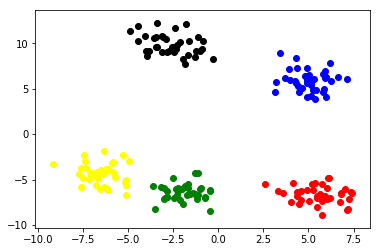

In [78]:
# dataset=sklearn.datasets.make_blobs(200,2,5)
df=pd.read_csv('gaussian.csv')
dataset=df.values
X=dataset[:,:-1]
Y=(dataset[:,-1])
print X.shape
col=['red','blue','green','yellow','black']
plt.figure(0)
for i in xrange(X.shape[0]):
    plt.scatter(X[i:i+1,0],X[i:i+1,1],color=col[int(Y[i])])
plt.show()

In [79]:
X.shape

(187, 2)

In [80]:
NNG_graph_adj_list=pnng(X)

In [81]:
Vbimeans,adj_list_bimeans=NNG_graph_adj_list

In [82]:
print Vbimeans.shape

(187, 2)


In [83]:
def line_plot(x1,y1,x2,y2,fig):
    plt.plot(np.linspace(x1,x2,100),np.linspace(y1,y2,100),c='green',lw=1,figure=fig)

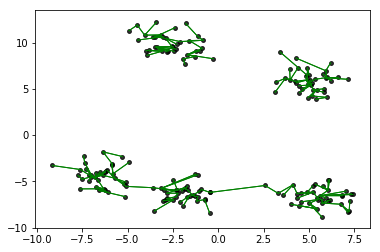

In [84]:
def mst_plot(V,adj_lisst):
    fig=plt.figure()
    for i in xrange(V.shape[0]):
#         print i,len(V[i])
        plt.scatter(V[i][0],V[i][1],color='black',alpha=0.8,s=15,figure=fig)
        for ed in adj_lisst[i]:
            line_plot(V[i][0],V[i][1],V[ed[0]][0],V[ed[0]][1],fig)
    plt.show()
mst_plot(Vbimeans,adj_list_bimeans)

In [85]:
Vkmeans,adj_list_kmeans=pnng(X,'K-means')

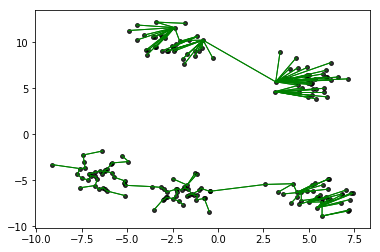

In [86]:
mst_plot(Vkmeans,adj_list_kmeans)

In [87]:
brute_adj_list=create_edges(X)

0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 2
43 2
44 2
45 2
46 2
47 2
48 2
49 2
50 2
51 2
52 2
53 2
54 2
55 2
56 2
57 2
58 2
59 2
60 2
61 2
62 2
63 2
64 2
65 2
66 2
67 2
68 2
69 2
70 2
71 2
72 2
73 2
74 2
75 2
76 2
77 2
78 2
79 2
80 2
81 2
82 2
83 2
84 2
85 2
86 2
87 2
88 2
89 2
90 2
91 2
92 2
93 2
94 2
95 2
96 2
97 2
98 2
99 2
100 2
101 2
102 2
103 2
104 2
105 2
106 2
107 2
108 2
109 2
110 2
111 2
112 2
113 2
114 2
115 2
116 2
117 2
118 2
119 2
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
135 2
136 2
137 2
138 2
139 2
140 2
141 2
142 2
143 2
144 2
145 2
146 2
147 2
148 2
149 2
150 2
151 2
152 2
153 2
154 2
155 2
156 2
157 2
158 2
159 2
160 2
161 2
162 2
163 2
164 2
165 2
166 2
167 2
168 2
169 2
170 2
171 2
172 2
173 2
174 2
175 2
176 2
177 2
178 2
179 2
180 2
181 2
182 2
183 2
184 2


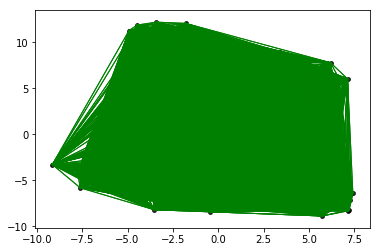

In [86]:
mst_plot(X,brute_adj_list)

In [88]:
brute_force_mst=prims_mst(brute_adj_list)

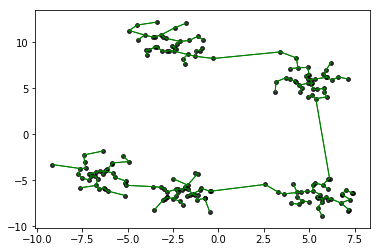

(187, 2)


In [89]:
mst_plot(X,brute_force_mst)
print X.shape

In [225]:
def c_comp_dfs(node,adj_lisst,mark,val,rem_edges=[]):
    if mark[node]:
        return
    mark[node]=val
    for edge in adj_lisst[node]:
        if (min(node,edge[0]),max(node,edge[0])) in rem_edges:
            continue
        if mark[edge[0]] or(min(node,edge[0]),max(node,edge[0])) in rem_edges :
            continue
        c_comp_dfs(edge[0],adj_lisst,mark,val,rem_edges)
    
def connected_components(V,adj_lisst,rem_edges=[]):
    mark=[0 for v in xrange(V.shape[0])]
    cnt=0
    for i in  xrange(V.shape[0]):
        if not mark[i]:
            cnt+=1
            c_comp_dfs(i,adj_lisst,mark,cnt,rem_edges)
    return cnt,mark


def pnng_cluster(V,adj_lisst,k=5):
    curr_no_of_clusters,_ = connected_components(V,adj_lisst)
    rem = max(0,k-curr_no_of_clusters)
    rem_edges=[]
    all_edges = {}
    for i in xrange(V.shape[0]):
        for ed in adj_lisst[i]:
            all_edges[(min(ed[0],i),max(ed[0],i),ed[1])]=0
    all_edges=all_edges.keys()
    all_edges.sort(key=lambda x: -x[2])
    rem_edges = all_edges[:rem]
    rem_edges=map(lambda x:(x[0],x[1]),rem_edges)
    return connected_components(V,adj_lisst,rem_edges)

In [236]:
cols=['Empty','Red','Blue','Green','Cyan','Brown']
def show_clusters(X,mark):
    plt.figure(0)
    for i in xrange(X.shape[0]):
        plt.scatter(X[i][0],X[i][1],c=cols[mark[i]])
    plt.show()

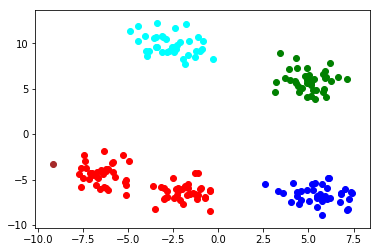

In [238]:
k,brute_mark=pnng_cluster(X,brute_force_mst)
show_clusters(X,brute_mark)

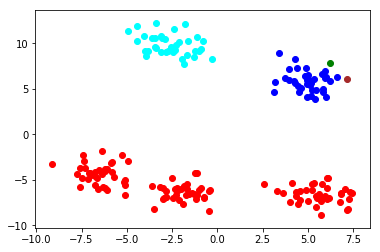

In [242]:
k,kmeans_mark=pnng_cluster(Vkmeans,adj_list_kmeans)
show_clusters(Vkmeans,kmeans_mark)

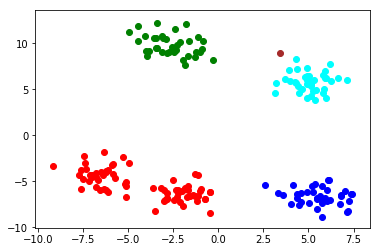

In [244]:
k,bimeans_mark=pnng_cluster(Vbimeans,adj_list_bimeans)
show_clusters(Vbimeans,bimeans_mark)

In [169]:
print brute_force_mst[45]

[(178, 8.728740303726989), (70, 0.4290267258955435), (68, 0.6338492241805042)]


In [224]:
plt.scatter?